In [1]:
import os
import shutil
import sys
import time
from PIL import Image
from datetime import date, datetime, timedelta


sys.path.insert(0, '..')
from utils import mongodb

In [2]:
from pesagensbalanca import cursor_pesagensbalanca, extract_to

# Gera base de dados de pesagens
Necessário acesso ao Banco de Dados ou ao Servidor

In [3]:
start = datetime(2020, 3, 1)
end = datetime.today()
limit = 10
s0 = time.time()
# cursor = cursor_pesagensbalanca(mongodb, start, end, limit, crop=True)
# count = extract_to(cursor, crop=True)
s1 = time.time()
# print('{:0.2f} segundos para processar {:d} registros'.format((s1 - s0), count))


# Carregar e montar modelo

In [3]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau



In [4]:
regression_model = models.Sequential([
  layers.Conv2D(16, (7, 7), activation='relu',
                padding='same',
                strides=(2, 2),
                input_shape=(144, 288, 3)),
  layers.MaxPooling2D(pool_size=(2, 4)),
  layers.Dropout(0.25),
  layers.Conv2D(16, (5, 5), 
                strides=(2, 2),
                activation='relu', padding='same'),
  layers.Dropout(0.25),
  layers.Conv2D(16, (5, 5), 
                strides=(2, 2),
                activation='relu'),
  layers.Dropout(0.25),
  layers.AvgPool2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(1)
 
])
regression_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 72, 144, 16)       2368      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 16)        6416      
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          6416      
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 16)          0

In [6]:
# regression_model.load_weights('gerabasespesagens_cropped2.hdf5')

In [7]:
for layer in regression_model.layers:
    print(layer, layer.trainable)


<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1e1026d438> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f1e1026da20> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f1e1026dc18> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1e1026dd68> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f1e10275208> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1e10275320> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f1e10275780> True
<tensorflow.python.keras.layers.pooling.AveragePooling2D object at 0x7f1e10275898> True
<tensorflow.python.keras.layers.core.Flatten object at 0x7f1e10275a90> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f1e10275be0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f1e10275ef0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f1e1027a240> True
<tensorflow.python.keras.layers.core.Dense objec

# Carregar e montar dados para treinamento

In [5]:
df = pd.read_pickle('df_final_filtered_pesagensbalanca.pkl')
df.head()

,id,pesobalanca,pesodeclarado,dif,filename,preds,dif_pred
1,5e5d09703d0ec8337863f9ee,29190,29149,41,5e5d09703d0ec8337863f9ee.jpg,23781.847656,5408.152344
3,5e5d099986556b3036c6dc6d,7610,7788,178,5e5d099986556b3036c6dc6d.jpg,7073.970215,536.029785
4,5e5d094386556b3036c6dc5c,22280,22300,20,5e5d094386556b3036c6dc5c.jpg,23390.078125,1110.078125
8,5e5d094386556b3036c6dc60,8420,8448,28,5e5d094386556b3036c6dc60.jpg,7730.686035,689.313965
10,5e5d09703d0ec8337863f9fa,9160,9516,356,5e5d09703d0ec8337863f9fa.jpg,10732.575195,1572.575195


In [6]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df.pesobalanca.values.reshape(-1, 1))


/home/ivan/pybr/projeto/venv/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
df['pesoscaled'] = scaled

In [8]:
df.describe()

,pesobalanca,pesodeclarado,dif,preds,dif_pred,pesoscaled
count,6652.000000,6652.000000,6652.000000,6652.000000,6652.000000,6.652000e+03
mean,18204.968581,18241.627330,214.162357,17884.900391,2167.843764,-1.068164e-16
std,7559.530088,7543.995047,205.533548,6904.848633,1561.269670,1.000075e+00
min,2370.000000,2211.000000,0.000000,4207.561523,0.507812,-2.094860e+00
25%,11240.000000,11305.750000,62.000000,10990.872559,831.310791,-9.214187e-01
50%,19695.000000,19790.000000,143.000000,19717.713867,1885.833008,1.971212e-01
75%,24160.000000,24160.000000,306.000000,24023.826660,3269.851196,7.878108e-01
max,29980.000000,30291.000000,999.000000,29644.216797,5998.706055,1.557758e+00


In [9]:
splitmask = np.random.rand(len(df)) < 0.8
df_train = df[splitmask]
df_val = df[~splitmask]

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory='../../bases/pesagensbalanca/pesagensbalanca_cropped',
    target_size=(144, 288),
    batch_size=256,
    x_col='filename',
    y_col="pesoscaled",
    shuffle=False,
    class_mode='raw',
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory='../../bases/pesagensbalanca/pesagensbalanca_cropped',
    target_size=(144, 288),
    batch_size=128,
    x_col='filename',
    y_col="pesoscaled",
    shuffle=False,
    class_mode='raw',
)

Found 5359 validated image filenames.
Found 1293 validated image filenames.


# Treinar modelo

In [14]:
regression_model.compile(optimizer=optimizers.Adam(lr=0.001),
                         loss='mean_absolute_error', metrics=['mse', 'mae', 'msle'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3,
                          verbose=1, mode='min')

In [15]:
regression_model.fit(train_generator, epochs=50, # shuffle=False,
                     callbacks=[reduce_lr],
                     validation_data = val_generator,
                     validation_steps = val_generator.samples // 128)

Train for 21 steps, validate for 10 steps
Epoch 1/50
21/21 [==============================] - 88s 4s/step - loss: 0.5824 - mse: 0.5593 - mae: 0.5804 - msle: 0.0850 - val_loss: 0.4482 - val_mse: 0.3594 - val_mae: 0.4482 - val_msle: 0.0633
Epoch 2/50
21/21 [==============================] - 59s 3s/step - loss: 0.4326 - mse: 0.3144 - mae: 0.4324 - msle: 0.0547 - val_loss: 0.4027 - val_mse: 0.2728 - val_mae: 0.4027 - val_msle: 0.0493
Epoch 3/50
21/21 [==============================] - 58s 3s/step - loss: 0.4029 - mse: 0.2668 - mae: 0.4029 - msle: 0.0457 - val_loss: 0.3965 - val_mse: 0.2517 - val_mae: 0.3965 - val_msle: 0.0480
Epoch 4/50
21/21 [==============================] - 56s 3s/step - loss: 0.3962 - mse: 0.2489 - mae: 0.3962 - msle: 0.0421 - val_loss: 0.3660 - val_mse: 0.2100 - val_mae: 0.3660 - val_msle: 0.0363
Epoch 5/50
21/21 [==============================] - 58s 3s/step - loss: 0.3826 - mse: 0.2296 - mae: 0.3826 - msle: 0.0381 - val_loss: 0.3477 - val_mse: 0.1844 - val_mae: 0.34

In [16]:
regression_model.save_weights('gerabasespesagens_cropped2_basefiltrada_scaled.hdf5')

In [11]:
regression_model.load_weights('gerabasespesagens_cropped2_basefiltrada_scaled.hdf5')

## Fine tunning

In [25]:
for layer in regression_model.layers:
    layer.trainable = True
for layer in regression_model.layers[:-4]:
    layer.trainable = False
for layer in regression_model.layers:
    print(layer, layer.trainable)


<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9329d44d68> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9329ccf390> False
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9329ccf588> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9329ccf6d8> False
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9329ccfb38> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9329ccfc50> False
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9329cdf0f0> False
<tensorflow.python.keras.layers.pooling.AveragePooling2D object at 0x7f9329cdf208> False
<tensorflow.python.keras.layers.core.Flatten object at 0x7f9329cdf400> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f9329cdf550> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9329cdf860> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9329cdfb70> True
<tensorflow.python.keras.layers.core.De

In [30]:
regression_model.compile(optimizer=optimizers.SGD(lr=0.001),
                         loss='mean_squared_logarithmic_error', metrics=['msle', 'mae', 'mse'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                          verbose=1, mode='min')

In [28]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory='../../bases/pesagensbalanca/pesagensbalanca_cropped',
    target_size=(144, 288),
    batch_size=128,
    x_col='filename',
    y_col="pesobalanca",
    shuffle=False,
    class_mode='raw',
)


Found 7283 validated image filenames.


In [31]:
regression_model.fit(train_generator, epochs=20, shuffle=False,
                     callbacks=[reduce_lr],
                     validation_data = val_generator,
                     validation_steps = val_generator.samples // 64)

Train for 57 steps, validate for 12 steps
Epoch 1/20
57/57 [==============================] - 71s 1s/step - loss: 0.0947 - msle: 0.0947 - mae: 3608.4629 - mse: 23316486.0000 - val_loss: 0.1091 - val_msle: 0.1091 - val_mae: 3562.4495 - val_mse: 23320314.0000
Epoch 2/20
57/57 [==============================] - 71s 1s/step - loss: 0.0960 - msle: 0.0960 - mae: 3634.3882 - mse: 23902398.0000 - val_loss: 0.1093 - val_msle: 0.1093 - val_mae: 3560.1953 - val_mse: 23409062.0000
Epoch 3/20
57/57 [==============================] - 69s 1s/step - loss: 0.0959 - msle: 0.0959 - mae: 3642.7004 - mse: 23762100.0000 - val_loss: 0.1079 - val_msle: 0.1079 - val_mae: 3559.0322 - val_mse: 23223136.0000
Epoch 4/20
57/57 [==============================] - 68s 1s/step - loss: 0.0953 - msle: 0.0953 - mae: 3632.0486 - mse: 23893478.0000 - val_loss: 0.1082 - val_msle: 0.1082 - val_mae: 3570.1289 - val_mse: 23299914.0000
Epoch 5/20
57/57 [==============================] - 88s 2s/step - loss: 0.0955 - msle: 0.0955 

In [67]:
regression_model.compile(optimizer=optimizers.SGD(lr=0.0001),
                         loss='mean_absolute_error', metrics=['msle', 'mae', 'mse'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                          verbose=1, mode='min')

In [68]:
regression_model.fit(train_generator, epochs=20, shuffle=False,
                     callbacks=[reduce_lr],
                     validation_data = val_generator,
                     validation_steps = val_generator.samples // 64)

Train for 57 steps, validate for 12 steps
Epoch 1/20
57/57 [==============================] - 68s 1s/step - loss: 5622.2075 - msle: 0.1992 - mae: 5624.1997 - mse: 55791784.0000 - val_loss: 3756.6118 - val_msle: 0.1211 - val_mae: 3756.6116 - val_mse: 26991670.0000
Epoch 2/20
57/57 [==============================] - 69s 1s/step - loss: 4039.2813 - msle: 0.1083 - mae: 4039.6230 - mse: 28704642.0000 - val_loss: 3569.9286 - val_msle: 0.1115 - val_mae: 3569.9285 - val_mse: 23872918.0000
Epoch 3/20
57/57 [==============================] - 68s 1s/step - loss: 3988.0034 - msle: 0.1053 - mae: 3987.5867 - mse: 27424336.0000 - val_loss: 3688.5720 - val_msle: 0.1213 - val_mae: 3688.5723 - val_mse: 26035480.0000
Epoch 4/20
57/57 [==============================] - 67s 1s/step - loss: 3891.8890 - msle: 0.1026 - mae: 3891.7432 - mse: 26609566.0000 - val_loss: 3542.2460 - val_msle: 0.1098 - val_mae: 3542.2463 - val_mse: 23128936.0000
Epoch 5/20
57/57 [==============================] - 67s 1s/step - loss

In [110]:
regression_model.save_weights('gerabasespesagens_cropped2_finetunning.h5')

# Avaliação

[24119.691] 27250


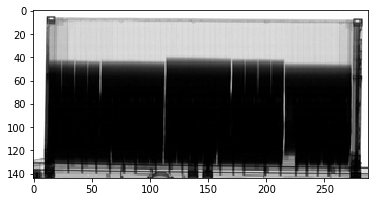

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
sample = df.sample()
filename = sample['filename'].item()
image = Image.open('../../bases/pesagensbalanca/pesagensbalanca_cropped/' + filename)
image = image.resize((288, 144), Image.LANCZOS)
image_array = np.expand_dims(np.array(image), axis=0) / 255
pred = regression_model.predict(image_array)[0][0]
pred_scaled = scaler.inverse_transform([pred])
print(pred_scaled, sample['pesobalanca'].item())
plt.imshow(image)

In [15]:
y_preds_train = regression_model.predict_generator(train_generator)

In [16]:
y_preds_val = regression_model.predict_generator(val_generator)

In [17]:
df_val.shape

(1293, 8)

In [18]:
y_preds_val.shape

(1293, 1)

In [19]:
df_val['preds'] = scaler.inverse_transform(y_preds_val)

/home/ivan/pybr/projeto/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
df_val.head()

,id,pesobalanca,pesodeclarado,dif,filename,preds,dif_pred,pesoscaled
12,5e5d099b86556b3036c6dcf7,8510,8714,204,5e5d099b86556b3036c6dcf7.jpg,11478.691406,2016.067383,-1.282579
30,5e5d09703d0ec8337863fa12,22850,22904,54,5e5d09703d0ec8337863fa12.jpg,27726.656250,3220.375000,0.614507
38,5e5d096a3d0ec8337863f7a9,26960,26776,184,5e5d096a3d0ec8337863f7a9.jpg,25050.500000,4361.814453,1.158232
39,5e5d096a3d0ec8337863f779,10960,10837,123,5e5d096a3d0ec8337863f779.jpg,10017.161133,756.332031,-0.958461
46,5e5d096b3d0ec8337863f7c9,23550,23740,190,5e5d096b3d0ec8337863f7c9.jpg,27755.988281,2927.474609,0.707112


In [21]:
df_val['dif_pred'] = abs(df_val['pesobalanca'] - df_val['preds'])

/home/ivan/pybr/projeto/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
df_val.describe()

,pesobalanca,pesodeclarado,dif,preds,dif_pred,pesoscaled
count,1293.000000,1293.000000,1293.000000,1293.000000,1293.000000,1293.000000
mean,18318.507347,18363.997680,219.309358,18414.128906,1887.850840,0.015020
std,7549.414613,7531.357979,208.275338,6778.143555,1653.910394,0.998737
min,2480.000000,2440.000000,0.000000,4225.133789,0.045898,-2.080308
25%,11660.000000,11600.000000,63.000000,11914.241211,557.063477,-0.865855
50%,19740.000000,19850.000000,153.000000,20475.013672,1388.701172,0.203074
75%,24160.000000,24170.000000,302.000000,23986.783203,2852.666016,0.787811
max,29970.000000,29994.000000,999.000000,29017.429688,9639.851562,1.556435


In [23]:
np.bincount(pd.np.digitize(df_val['dif_pred'], bins = [1000, 2000, 3000, 4000]))

array([518, 279, 202, 128, 166])

In [24]:
sum(df_val.dif_pred > 4000)

166

In [25]:
df_train['preds'] = scaler.inverse_transform(y_preds_train)

/home/ivan/pybr/projeto/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [26]:
df_train['dif_pred'] = abs(df_train['pesobalanca'] - df_train['preds'])

/home/ivan/pybr/projeto/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
df_train.describe()

,pesobalanca,pesodeclarado,dif,preds,dif_pred,pesoscaled
count,5359.000000,5359.000000,5359.000000,5359.000000,5359.000000,5359.000000
mean,18177.574361,18212.102258,212.920508,18225.839844,1918.167514,-0.003624
std,7562.417137,7547.445642,204.866791,6735.773438,1669.910334,1.000457
min,2370.000000,2211.000000,0.000000,3894.776123,0.287109,-2.094860
25%,11170.000000,11247.000000,62.000000,11505.944824,585.954102,-0.930679
50%,19690.000000,19790.000000,140.000000,19992.458984,1420.400391,0.196460
75%,24165.000000,24158.000000,307.000000,23862.916016,2987.787109,0.788472
max,29980.000000,30291.000000,999.000000,30525.386719,12810.359375,1.557758


In [28]:
np.bincount(pd.np.digitize(df_train['dif_pred'], bins = [1000, 2000, 3000, 4000]))

array([2118, 1173,  736,  665,  667])

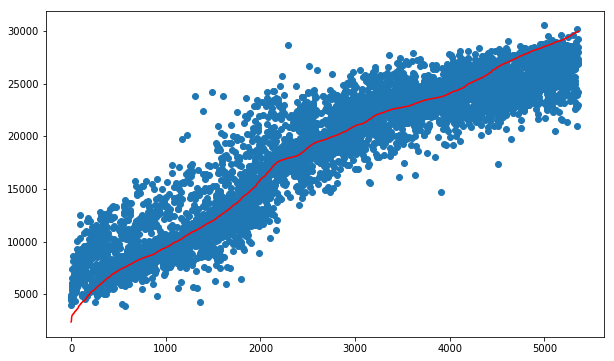

In [37]:
plt.figure(figsize=(10,6))
df_sorted = df_train.sort_values(by='pesobalanca')
x = range(len(df_sorted))
plt.scatter(x=x, y=list(df_sorted.preds))
plt.plot(list(df_sorted.pesobalanca), color='r')


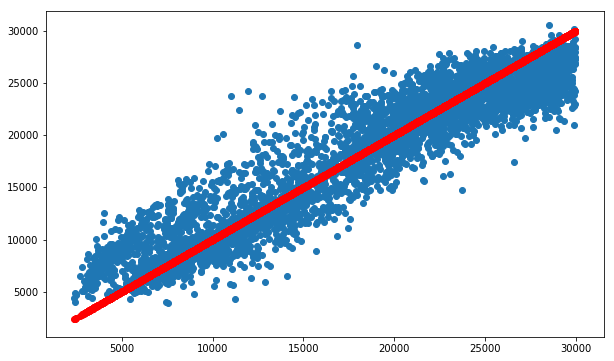

In [38]:
plt.figure(figsize=(10,6))
plt.scatter(x=list(df_sorted.pesobalanca), y=list(df_sorted.preds))
plt.scatter(x=list(df_sorted.pesobalanca), y=list(df_sorted.pesobalanca), color='r')

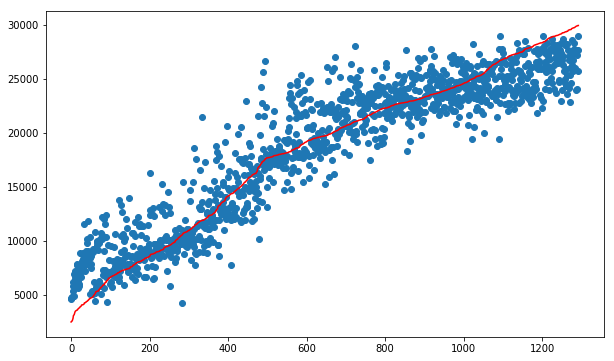

In [39]:
plt.figure(figsize=(10,6))
df_sorted = df_val.sort_values(by='pesobalanca')
x = range(len(df_sorted))
plt.scatter(x=x, y=list(df_sorted.preds))
plt.plot(list(df_sorted.pesobalanca), color='r')

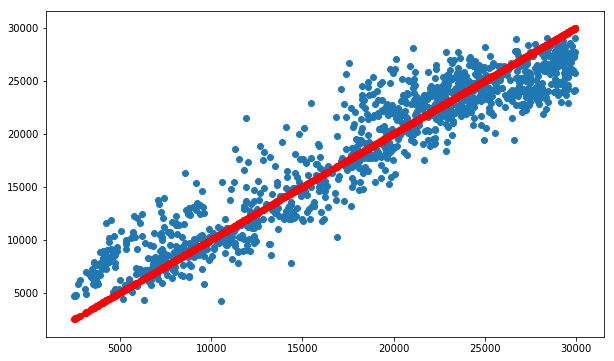

In [40]:
plt.figure(figsize=(10,6))
plt.scatter(x=list(df_sorted.pesobalanca), y=list(df_sorted.preds))
plt.scatter(x=list(df_sorted.pesobalanca), y=list(df_sorted.pesobalanca), color='r')